## 📦 Importar Bibliotecas

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✅ Bibliotecas importadas!")

✅ Bibliotecas importadas!


## 🎲 Criar Dataset de Exemplo

In [4]:
np.random.seed(42)
n = 1000

# Features categóricas
df = pd.DataFrame({
    # Nominal (sem ordem)
    'cidade': np.random.choice(['São Paulo', 'Rio de Janeiro', 'Belo Horizonte', 'Brasília', 'Curitiba'], n),
    'departamento': np.random.choice(['TI', 'Vendas', 'RH', 'Financeiro', 'Marketing'], n),
    
    # Ordinal (com ordem)
    'educacao': np.random.choice(['Fundamental', 'Médio', 'Superior', 'Pós-Graduação'], n),
    'nivel_cargo': np.random.choice(['Junior', 'Pleno', 'Senior', 'Gerente'], n),
    
    # Alta cardinalidade
    'cargo_especifico': np.random.choice(
        ['Analista I', 'Analista II', 'Analista III', 'Coordenador', 
         'Especialista', 'Consultor', 'Gerente', 'Diretor',
         'Assistente', 'Estagiário', 'Trainee', 'Supervisor'], n
    ),
    
    # Features numéricas
    'idade': np.random.randint(22, 60, n),
    'anos_empresa': np.random.randint(0, 20, n),
})

# Target: promovido (baseado em regras)
df['promovido'] = (
    (df['anos_empresa'] > 5) &
    (df['educacao'].isin(['Superior', 'Pós-Graduação'])) &
    (df['nivel_cargo'].isin(['Pleno', 'Senior']))
).astype(int)

# Adicionar ruído
noise = np.random.random(n) < 0.15
df.loc[noise, 'promovido'] = 1 - df.loc[noise, 'promovido']

print(f"✅ Dataset criado: {df.shape}")
print(f"\n📊 Target:")
print(df['promovido'].value_counts())
print(f"\n📈 Amostra:")
df.head(10)

✅ Dataset criado: (1000, 8)

📊 Target:
promovido
0    738
1    262
Name: count, dtype: int64

📈 Amostra:


,cidade,departamento,educacao,nivel_cargo,cargo_especifico,idade,anos_empresa,promovido
0,Brasília,Financeiro,Pós-Graduação,Pleno,Especialista,51,11,1
1,Curitiba,Financeiro,Superior,Gerente,Analista III,38,8,0
2,Belo Horizonte,Financeiro,Pós-Graduação,Pleno,Assistente,53,9,1
3,Curitiba,Financeiro,Superior,Junior,Assistente,35,1,0
4,Curitiba,Marketing,Médio,Senior,Consultor,31,15,0
5,Rio de Janeiro,Marketing,Fundamental,Pleno,Analista I,57,19,0
6,Belo Horizonte,Vendas,Médio,Junior,Gerente,55,6,0
7,Belo Horizonte,TI,Fundamental,Gerente,Gerente,30,1,0
8,Belo Horizonte,Financeiro,Fundamental,Pleno,Estagiário,49,0,0
9,Curitiba,Vendas,Fundamental,Senior,Estagiário,32,18,0


## 📊 Análise Exploratória

In [5]:
# Info do dataset
print("📋 Informações do Dataset:\n")
print(df.info())

print("\n" + "="*60)
print("\n📊 Cardinalidade das Features Categóricas:\n")

cat_cols = ['cidade', 'departamento', 'educacao', 'nivel_cargo', 'cargo_especifico']
for col in cat_cols:
    n_unique = df[col].nunique()
    print(f"{col:20s}: {n_unique:2d} categorias únicas")
    
print("\n" + "="*60)

📋 Informações do Dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cidade            1000 non-null   object
 1   departamento      1000 non-null   object
 2   educacao          1000 non-null   object
 3   nivel_cargo       1000 non-null   object
 4   cargo_especifico  1000 non-null   object
 5   idade             1000 non-null   int32 
 6   anos_empresa      1000 non-null   int32 
 7   promovido         1000 non-null   int64 
dtypes: int32(2), int64(1), object(5)
memory usage: 54.8+ KB
None


📊 Cardinalidade das Features Categóricas:

cidade              :  5 categorias únicas
departamento        :  5 categorias únicas
educacao            :  4 categorias únicas
nivel_cargo         :  4 categorias únicas
cargo_especifico    : 12 categorias únicas



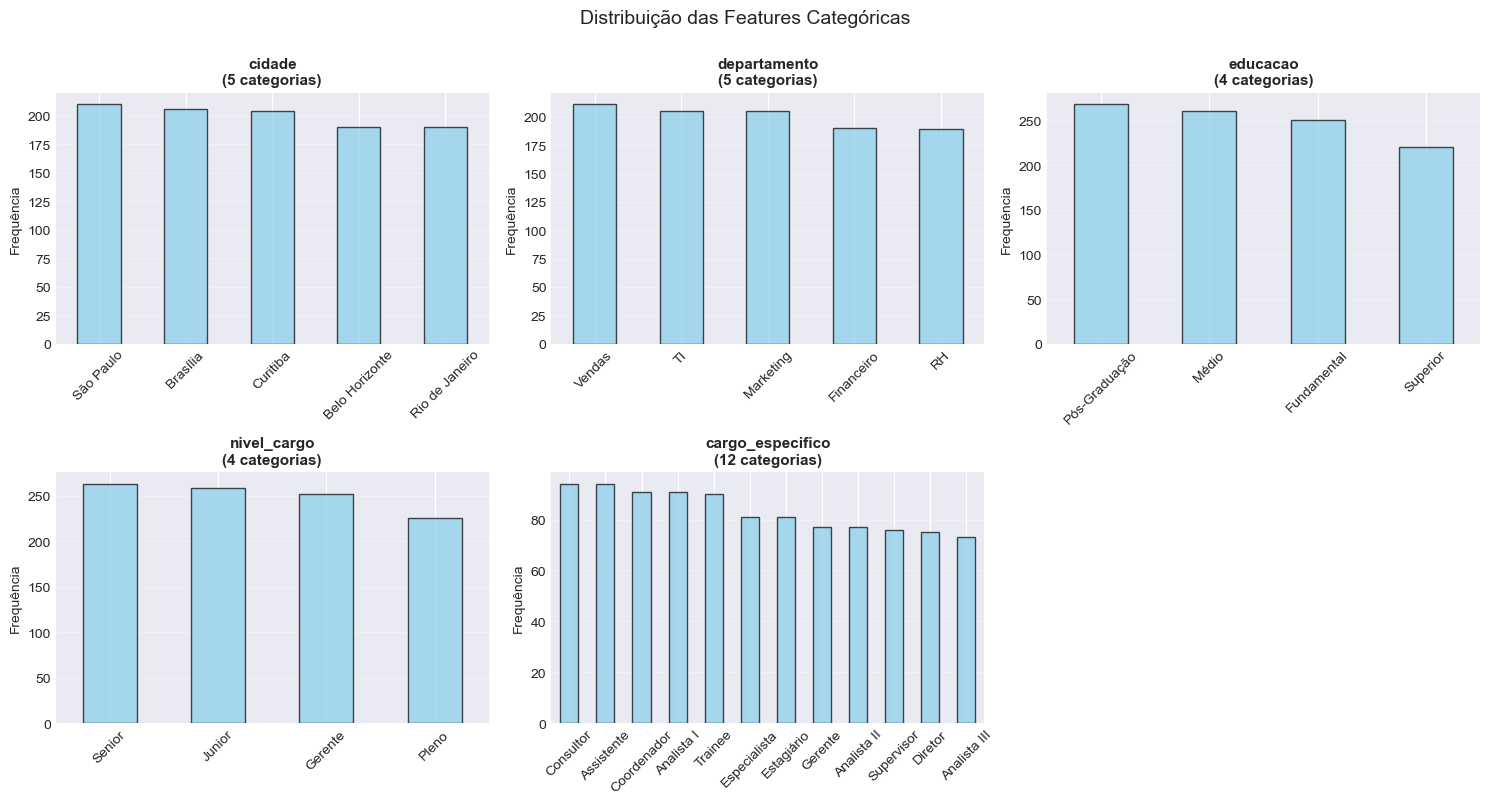

In [6]:
# Visualizar distribuições
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Distribuição das Features Categóricas', fontsize=14, y=1.00)

for idx, col in enumerate(cat_cols):
    ax = axes[idx // 3, idx % 3]
    
    counts = df[col].value_counts()
    counts.plot(kind='bar', ax=ax, color='skyblue', alpha=0.7, edgecolor='black')
    
    ax.set_title(f'{col}\n({len(counts)} categorias)', fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Frequência')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

# Remover subplot vazio
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

## 1️⃣ One-Hot Encoding

Cria uma coluna binária (0 ou 1) para cada categoria.

In [7]:
# One-Hot Encoding com pandas
df_onehot = pd.get_dummies(
    df, 
    columns=['cidade', 'departamento'],
    prefix=['cidade', 'depto'],
    drop_first=True  # Evita multicolinearidade
)

print("✅ One-Hot Encoding aplicado!\n")
print(f"Shape original: {df.shape}")
print(f"Shape após OHE: {df_onehot.shape}")
print(f"\nNovas colunas criadas: {df_onehot.shape[1] - df.shape[1]}")

print("\n📋 Colunas criadas:")
new_cols = [col for col in df_onehot.columns if col.startswith(('cidade_', 'depto_'))]
print(new_cols)

print("\n📊 Amostra:")
df_onehot[['cidade_Rio de Janeiro', 'cidade_São Paulo', 'depto_TI', 'depto_Vendas', 'promovido']].head(10)

✅ One-Hot Encoding aplicado!

Shape original: (1000, 8)
Shape após OHE: (1000, 14)

Novas colunas criadas: 6

📋 Colunas criadas:
['cidade_Brasília', 'cidade_Curitiba', 'cidade_Rio de Janeiro', 'cidade_São Paulo', 'depto_Marketing', 'depto_RH', 'depto_TI', 'depto_Vendas']

📊 Amostra:


,cidade_Rio de Janeiro,cidade_São Paulo,depto_TI,depto_Vendas,promovido
0,False,False,False,False,1
1,False,False,False,False,0
2,False,False,False,False,1
3,False,False,False,False,0
4,False,False,False,False,0
5,True,False,False,False,0
6,False,False,False,True,0
7,False,False,True,False,0
8,False,False,False,False,0
9,False,False,False,True,0


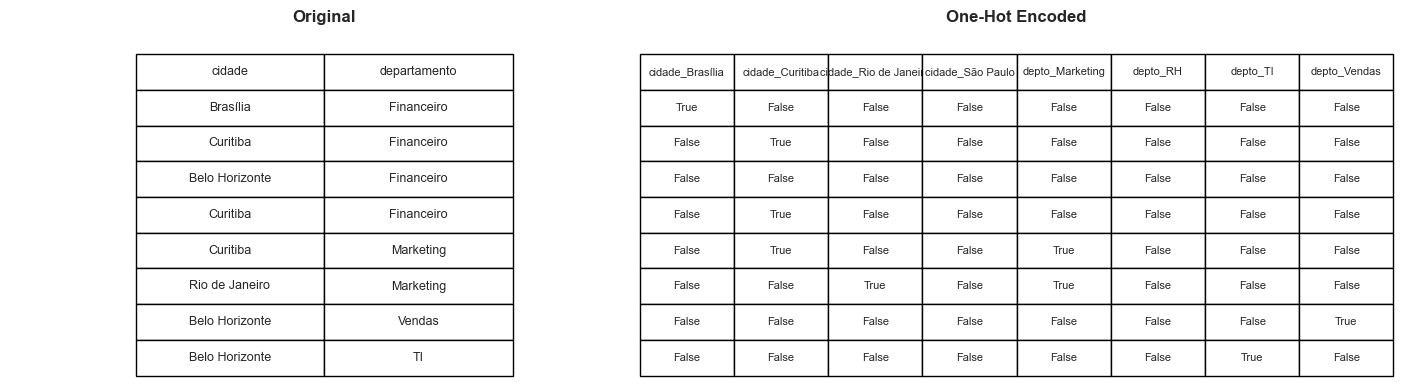


📌 One-Hot Encoding:
✅ Melhor para: features nominais (sem ordem)
✅ Funciona com: todos os algoritmos
⚠️ Cuidado: aumenta dimensionalidade (muitas colunas se muitas categorias)
⚠️ Use drop_first=True para evitar multicolinearidade


In [8]:
# Visualizar exemplo
sample = df[['cidade', 'departamento']].head(8)
sample_encoded = df_onehot[new_cols].head(8)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Original
axes[0].axis('tight')
axes[0].axis('off')
table1 = axes[0].table(
    cellText=sample.values,
    colLabels=sample.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.3, 0.3]
)
table1.auto_set_font_size(False)
table1.set_fontsize(9)
table1.scale(1, 2)
axes[0].set_title('Original', fontsize=12, fontweight='bold', pad=20)

# One-Hot Encoded
axes[1].axis('tight')
axes[1].axis('off')
table2 = axes[1].table(
    cellText=sample_encoded.values,
    colLabels=sample_encoded.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.15] * len(sample_encoded.columns)
)
table2.auto_set_font_size(False)
table2.set_fontsize(8)
table2.scale(1, 2)
axes[1].set_title('One-Hot Encoded', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\n📌 One-Hot Encoding:")
print("✅ Melhor para: features nominais (sem ordem)")
print("✅ Funciona com: todos os algoritmos")
print("⚠️ Cuidado: aumenta dimensionalidade (muitas colunas se muitas categorias)")
print("⚠️ Use drop_first=True para evitar multicolinearidade")

## 2️⃣ Label Encoding

Atribui um número inteiro a cada categoria.

In [9]:
# Label Encoding
df_label = df.copy()

le_dept = LabelEncoder()
df_label['departamento_encoded'] = le_dept.fit_transform(df_label['departamento'])

le_city = LabelEncoder()
df_label['cidade_encoded'] = le_city.fit_transform(df_label['cidade'])

print("✅ Label Encoding aplicado!\n")

# Mostrar mapeamento
print("📊 Mapeamento Departamento:")
dept_mapping = dict(zip(le_dept.classes_, le_dept.transform(le_dept.classes_)))
for cat, code in dept_mapping.items():
    print(f"  {cat:15s} → {code}")

print("\n📊 Mapeamento Cidade:")
city_mapping = dict(zip(le_city.classes_, le_city.transform(le_city.classes_)))
for cat, code in city_mapping.items():
    print(f"  {cat:20s} → {code}")

print("\n📈 Amostra:")
df_label[['departamento', 'departamento_encoded', 'cidade', 'cidade_encoded']].head(10)

✅ Label Encoding aplicado!

📊 Mapeamento Departamento:
  Financeiro      → 0
  Marketing       → 1
  RH              → 2
  TI              → 3
  Vendas          → 4

📊 Mapeamento Cidade:
  Belo Horizonte       → 0
  Brasília             → 1
  Curitiba             → 2
  Rio de Janeiro       → 3
  São Paulo            → 4

📈 Amostra:


,departamento,departamento_encoded,cidade,cidade_encoded
0,Financeiro,0,Brasília,1
1,Financeiro,0,Curitiba,2
2,Financeiro,0,Belo Horizonte,0
3,Financeiro,0,Curitiba,2
4,Marketing,1,Curitiba,2
5,Marketing,1,Rio de Janeiro,3
6,Vendas,4,Belo Horizonte,0
7,TI,3,Belo Horizonte,0
8,Financeiro,0,Belo Horizonte,0
9,Vendas,4,Curitiba,2


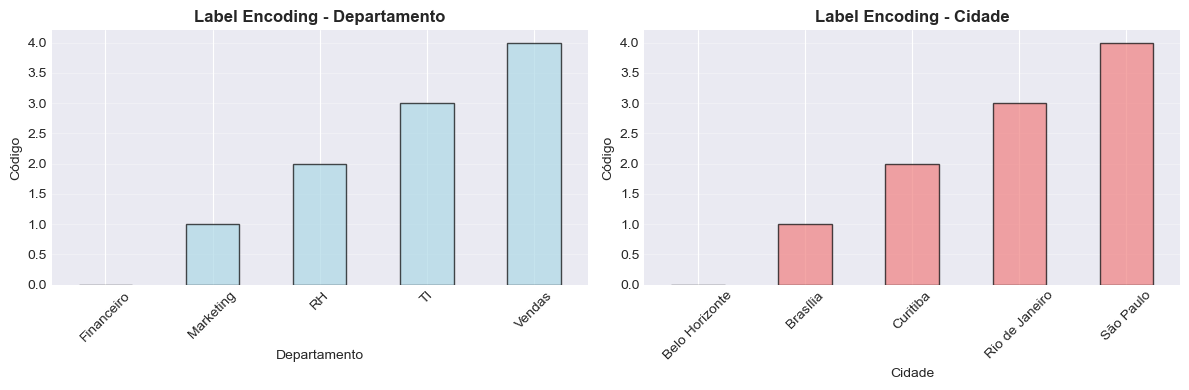


📌 Label Encoding:
✅ Simples e rápido
✅ Não aumenta dimensionalidade
⚠️ PROBLEMA: Cria ordem artificial (Financeiro=0, Marketing=1, RH=2...)
⚠️ Use apenas para: features ordinais ou target variable
✅ OK para: Árvores de decisão (ignoram ordem)
❌ EVITE para: Regressão Linear, SVM, Neural Networks


In [10]:
# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Departamento
df_label.groupby(['departamento', 'departamento_encoded']).size().reset_index(name='count').plot(
    x='departamento', y='departamento_encoded', kind='bar', ax=axes[0], 
    color='lightblue', alpha=0.7, edgecolor='black', legend=False
)
axes[0].set_title('Label Encoding - Departamento', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Departamento')
axes[0].set_ylabel('Código')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Cidade
df_label.groupby(['cidade', 'cidade_encoded']).size().reset_index(name='count').plot(
    x='cidade', y='cidade_encoded', kind='bar', ax=axes[1],
    color='lightcoral', alpha=0.7, edgecolor='black', legend=False
)
axes[1].set_title('Label Encoding - Cidade', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cidade')
axes[1].set_ylabel('Código')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📌 Label Encoding:")
print("✅ Simples e rápido")
print("✅ Não aumenta dimensionalidade")
print("⚠️ PROBLEMA: Cria ordem artificial (Financeiro=0, Marketing=1, RH=2...)")
print("⚠️ Use apenas para: features ordinais ou target variable")
print("✅ OK para: Árvores de decisão (ignoram ordem)")
print("❌ EVITE para: Regressão Linear, SVM, Neural Networks")

## 3️⃣ Ordinal Encoding

Label Encoding com ordem definida (para features ordinais).

In [11]:
# Ordinal Encoding com ordem definida
df_ordinal = df.copy()

# Definir ordem correta
educacao_order = ['Fundamental', 'Médio', 'Superior', 'Pós-Graduação']
cargo_order = ['Junior', 'Pleno', 'Senior', 'Gerente']

# Aplicar
ordinal_enc_edu = OrdinalEncoder(categories=[educacao_order])
df_ordinal['educacao_encoded'] = ordinal_enc_edu.fit_transform(df_ordinal[['educacao']])

ordinal_enc_cargo = OrdinalEncoder(categories=[cargo_order])
df_ordinal['nivel_cargo_encoded'] = ordinal_enc_cargo.fit_transform(df_ordinal[['nivel_cargo']])

print("✅ Ordinal Encoding aplicado!\n")

print("📊 Mapeamento Educação:")
for idx, edu in enumerate(educacao_order):
    print(f"  {edu:20s} → {idx}")

print("\n📊 Mapeamento Nível Cargo:")
for idx, cargo in enumerate(cargo_order):
    print(f"  {cargo:15s} → {idx}")

print("\n📈 Amostra:")
df_ordinal[['educacao', 'educacao_encoded', 'nivel_cargo', 'nivel_cargo_encoded']].head(10)

✅ Ordinal Encoding aplicado!

📊 Mapeamento Educação:
  Fundamental          → 0
  Médio                → 1
  Superior             → 2
  Pós-Graduação        → 3

📊 Mapeamento Nível Cargo:
  Junior          → 0
  Pleno           → 1
  Senior          → 2
  Gerente         → 3

📈 Amostra:


,educacao,educacao_encoded,nivel_cargo,nivel_cargo_encoded
0,Pós-Graduação,3.0,Pleno,1.0
1,Superior,2.0,Gerente,3.0
2,Pós-Graduação,3.0,Pleno,1.0
3,Superior,2.0,Junior,0.0
4,Médio,1.0,Senior,2.0
5,Fundamental,0.0,Pleno,1.0
6,Médio,1.0,Junior,0.0
7,Fundamental,0.0,Gerente,3.0
8,Fundamental,0.0,Pleno,1.0
9,Fundamental,0.0,Senior,2.0


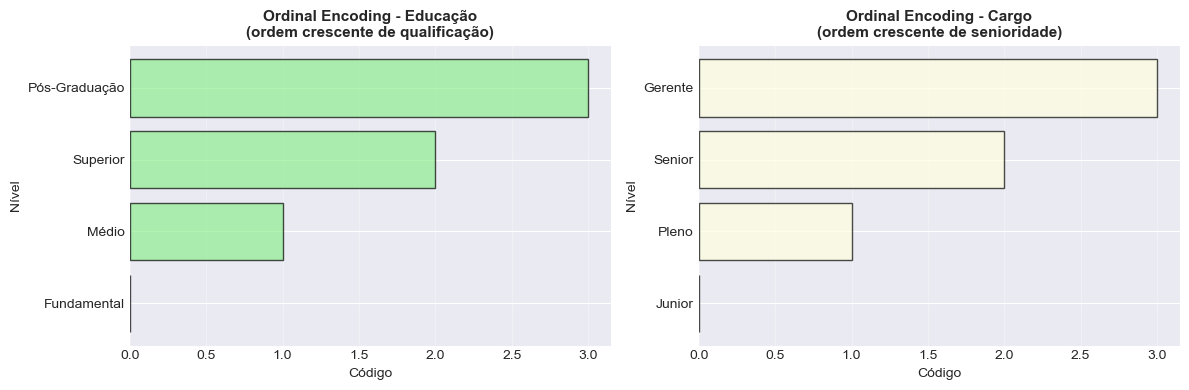


📌 Ordinal Encoding:
✅ Perfeito para features com ordem natural
✅ Captura a hierarquia (Junior < Pleno < Senior)
✅ Você define a ordem correta
✅ Funciona bem com todos os algoritmos


In [12]:
# Visualizar ordem
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Educação
edu_order_plot = df_ordinal.groupby(['educacao', 'educacao_encoded']).size().reset_index(name='count')
edu_order_plot = edu_order_plot.sort_values('educacao_encoded')

axes[0].barh(edu_order_plot['educacao'], edu_order_plot['educacao_encoded'], 
             color='lightgreen', alpha=0.7, edgecolor='black')
axes[0].set_title('Ordinal Encoding - Educação\n(ordem crescente de qualificação)', 
                  fontsize=11, fontweight='bold')
axes[0].set_xlabel('Código')
axes[0].set_ylabel('Nível')
axes[0].grid(True, alpha=0.3, axis='x')

# Cargo
cargo_order_plot = df_ordinal.groupby(['nivel_cargo', 'nivel_cargo_encoded']).size().reset_index(name='count')
cargo_order_plot = cargo_order_plot.sort_values('nivel_cargo_encoded')

axes[1].barh(cargo_order_plot['nivel_cargo'], cargo_order_plot['nivel_cargo_encoded'],
             color='lightyellow', alpha=0.7, edgecolor='black')
axes[1].set_title('Ordinal Encoding - Cargo\n(ordem crescente de senioridade)', 
                  fontsize=11, fontweight='bold')
axes[1].set_xlabel('Código')
axes[1].set_ylabel('Nível')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📌 Ordinal Encoding:")
print("✅ Perfeito para features com ordem natural")
print("✅ Captura a hierarquia (Junior < Pleno < Senior)")
print("✅ Você define a ordem correta")
print("✅ Funciona bem com todos os algoritmos")

## 4️⃣ Target Encoding (Mean Encoding)

Substitui cada categoria pela média do target para aquela categoria.

In [13]:
# Target Encoding
df_target = df.copy()

# Calcular média do target por categoria
cidade_target_mean = df_target.groupby('cidade')['promovido'].mean()
dept_target_mean = df_target.groupby('departamento')['promovido'].mean()

# Aplicar encoding
df_target['cidade_target_enc'] = df_target['cidade'].map(cidade_target_mean)
df_target['depto_target_enc'] = df_target['departamento'].map(dept_target_mean)

print("✅ Target Encoding aplicado!\n")

print("📊 Target Encoding - Cidade:")
print(cidade_target_mean.sort_values(ascending=False))

print("\n📊 Target Encoding - Departamento:")
print(dept_target_mean.sort_values(ascending=False))

print("\n📈 Amostra:")
df_target[['cidade', 'cidade_target_enc', 'departamento', 'depto_target_enc', 'promovido']].head(10)

✅ Target Encoding aplicado!

📊 Target Encoding - Cidade:
cidade
Rio de Janeiro    0.289474
Belo Horizonte    0.278947
Curitiba          0.259804
Brasília          0.252427
São Paulo         0.233333
Name: promovido, dtype: float64

📊 Target Encoding - Departamento:
departamento
TI            0.292683
RH            0.291005
Marketing     0.258537
Vendas        0.241706
Financeiro    0.226316
Name: promovido, dtype: float64

📈 Amostra:


,cidade,cidade_target_enc,departamento,depto_target_enc,promovido
0,Brasília,0.252427,Financeiro,0.226316,1
1,Curitiba,0.259804,Financeiro,0.226316,0
2,Belo Horizonte,0.278947,Financeiro,0.226316,1
3,Curitiba,0.259804,Financeiro,0.226316,0
4,Curitiba,0.259804,Marketing,0.258537,0
5,Rio de Janeiro,0.289474,Marketing,0.258537,0
6,Belo Horizonte,0.278947,Vendas,0.241706,0
7,Belo Horizonte,0.278947,TI,0.292683,0
8,Belo Horizonte,0.278947,Financeiro,0.226316,0
9,Curitiba,0.259804,Vendas,0.241706,0


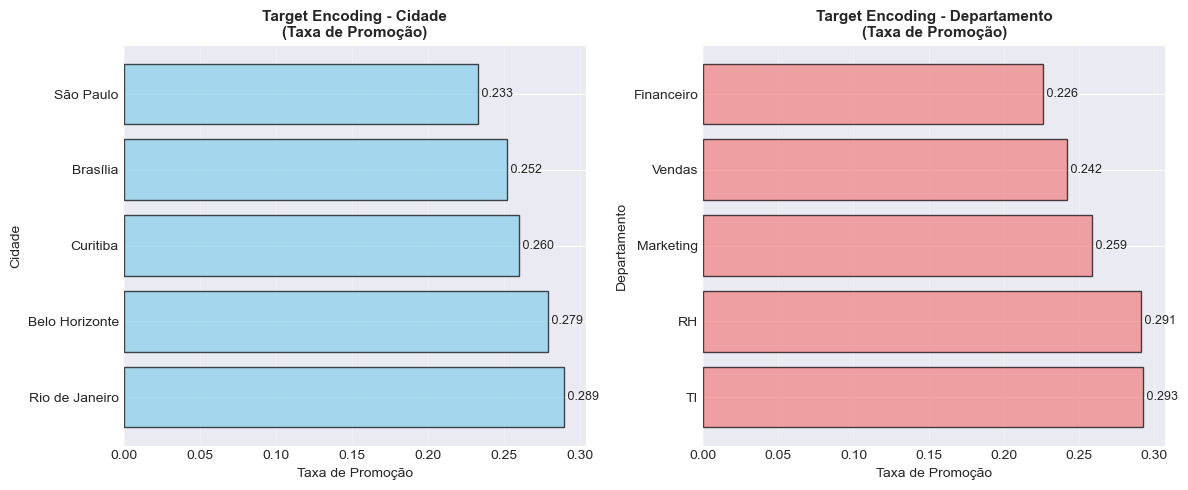


📌 Target Encoding:
✅ Ótimo para alta cardinalidade (muitas categorias)
✅ Captura relação com target
✅ Não aumenta dimensionalidade
⚠️ RISCO: Overfitting e data leakage!
⚠️ IMPORTANTE: Calcular no train, aplicar no test
⚠️ Considere usar cross-validation encoding


In [14]:
# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Cidade
cidade_stats = df_target.groupby('cidade').agg({
    'promovido': 'mean',
    'cidade_target_enc': 'first'
}).sort_values('promovido', ascending=False)

axes[0].barh(cidade_stats.index, cidade_stats['promovido'], 
             color='skyblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Target Encoding - Cidade\n(Taxa de Promoção)', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Taxa de Promoção')
axes[0].set_ylabel('Cidade')
axes[0].grid(True, alpha=0.3, axis='x')

# Adicionar valores
for idx, (city, val) in enumerate(zip(cidade_stats.index, cidade_stats['promovido'])):
    axes[0].text(val, idx, f' {val:.3f}', va='center', fontsize=9)

# Departamento
dept_stats = df_target.groupby('departamento').agg({
    'promovido': 'mean',
    'depto_target_enc': 'first'
}).sort_values('promovido', ascending=False)

axes[1].barh(dept_stats.index, dept_stats['promovido'],
             color='lightcoral', alpha=0.7, edgecolor='black')
axes[1].set_title('Target Encoding - Departamento\n(Taxa de Promoção)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Taxa de Promoção')
axes[1].set_ylabel('Departamento')
axes[1].grid(True, alpha=0.3, axis='x')

for idx, (dept, val) in enumerate(zip(dept_stats.index, dept_stats['promovido'])):
    axes[1].text(val, idx, f' {val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📌 Target Encoding:")
print("✅ Ótimo para alta cardinalidade (muitas categorias)")
print("✅ Captura relação com target")
print("✅ Não aumenta dimensionalidade")
print("⚠️ RISCO: Overfitting e data leakage!")
print("⚠️ IMPORTANTE: Calcular no train, aplicar no test")
print("⚠️ Considere usar cross-validation encoding")

## 5️⃣ Frequency Encoding

Substitui cada categoria pela sua frequência.

In [15]:
# Frequency Encoding
df_freq = df.copy()

# Calcular frequências
cidade_freq = df_freq['cidade'].value_counts(normalize=True)
dept_freq = df_freq['departamento'].value_counts(normalize=True)

# Aplicar encoding
df_freq['cidade_freq_enc'] = df_freq['cidade'].map(cidade_freq)
df_freq['depto_freq_enc'] = df_freq['departamento'].map(dept_freq)

print("✅ Frequency Encoding aplicado!\n")

print("📊 Frequency Encoding - Cidade:")
print(cidade_freq.sort_values(ascending=False))

print("\n📊 Frequency Encoding - Departamento:")
print(dept_freq.sort_values(ascending=False))

print("\n📈 Amostra:")
df_freq[['cidade', 'cidade_freq_enc', 'departamento', 'depto_freq_enc']].head(10)

✅ Frequency Encoding aplicado!

📊 Frequency Encoding - Cidade:
cidade
São Paulo         0.210
Brasília          0.206
Curitiba          0.204
Belo Horizonte    0.190
Rio de Janeiro    0.190
Name: proportion, dtype: float64

📊 Frequency Encoding - Departamento:
departamento
Vendas        0.211
TI            0.205
Marketing     0.205
Financeiro    0.190
RH            0.189
Name: proportion, dtype: float64

📈 Amostra:


,cidade,cidade_freq_enc,departamento,depto_freq_enc
0,Brasília,0.206,Financeiro,0.190
1,Curitiba,0.204,Financeiro,0.190
2,Belo Horizonte,0.190,Financeiro,0.190
3,Curitiba,0.204,Financeiro,0.190
4,Curitiba,0.204,Marketing,0.205
5,Rio de Janeiro,0.190,Marketing,0.205
6,Belo Horizonte,0.190,Vendas,0.211
7,Belo Horizonte,0.190,TI,0.205
8,Belo Horizonte,0.190,Financeiro,0.190
9,Curitiba,0.204,Vendas,0.211


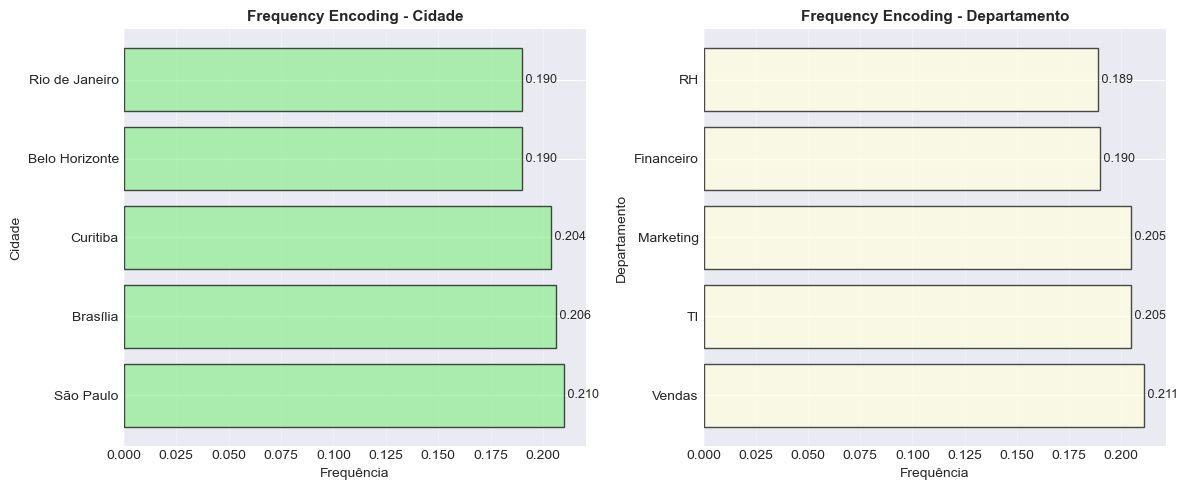


📌 Frequency Encoding:
✅ Simples e rápido
✅ Não aumenta dimensionalidade
✅ Sem risco de data leakage
⚠️ Pode ter colisões (categorias diferentes com mesma frequência)
⚠️ Não captura relação com target


In [16]:
# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Cidade
axes[0].barh(cidade_freq.index, cidade_freq.values, 
             color='lightgreen', alpha=0.7, edgecolor='black')
axes[0].set_title('Frequency Encoding - Cidade', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Frequência')
axes[0].set_ylabel('Cidade')
axes[0].grid(True, alpha=0.3, axis='x')

for idx, (city, freq) in enumerate(zip(cidade_freq.index, cidade_freq.values)):
    axes[0].text(freq, idx, f' {freq:.3f}', va='center', fontsize=9)

# Departamento
axes[1].barh(dept_freq.index, dept_freq.values,
             color='lightyellow', alpha=0.7, edgecolor='black')
axes[1].set_title('Frequency Encoding - Departamento', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Frequência')
axes[1].set_ylabel('Departamento')
axes[1].grid(True, alpha=0.3, axis='x')

for idx, (dept, freq) in enumerate(zip(dept_freq.index, dept_freq.values)):
    axes[1].text(freq, idx, f' {freq:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📌 Frequency Encoding:")
print("✅ Simples e rápido")
print("✅ Não aumenta dimensionalidade")
print("✅ Sem risco de data leakage")
print("⚠️ Pode ter colisões (categorias diferentes com mesma frequência)")
print("⚠️ Não captura relação com target")

## 🎯 Comparação de Performance

Vamos comparar todos os encodings treinando modelos.

In [17]:
# Preparar datasets com diferentes encodings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Features e target
feature_cols = ['cidade', 'departamento', 'educacao', 'nivel_cargo', 'idade', 'anos_empresa']
X = df[feature_cols]
y = df['promovido']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Dados preparados!")
print(f"Train: {X_train.shape}")
print(f"Test:  {X_test.shape}")

✅ Dados preparados!
Train: (800, 6)
Test:  (200, 6)


In [18]:
# 1. One-Hot Encoding
X_train_ohe = pd.get_dummies(X_train, drop_first=True)
X_test_ohe = pd.get_dummies(X_test, drop_first=True)

# Garantir mesmas colunas
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

# 2. Label Encoding
X_train_le = X_train.copy()
X_test_le = X_test.copy()

cat_cols_nominal = ['cidade', 'departamento', 'educacao', 'nivel_cargo']
for col in cat_cols_nominal:
    le = LabelEncoder()
    X_train_le[col] = le.fit_transform(X_train_le[col])
    X_test_le[col] = le.transform(X_test_le[col])

# 3. Ordinal Encoding
X_train_ord = X_train.copy()
X_test_ord = X_test.copy()

# Nominais com Label
for col in ['cidade', 'departamento']:
    le = LabelEncoder()
    X_train_ord[col] = le.fit_transform(X_train_ord[col])
    X_test_ord[col] = le.transform(X_test_ord[col])

# Ordinais com ordem
educacao_order = ['Fundamental', 'Médio', 'Superior', 'Pós-Graduação']
cargo_order = ['Junior', 'Pleno', 'Senior', 'Gerente']

ord_enc_edu = OrdinalEncoder(categories=[educacao_order])
X_train_ord['educacao'] = ord_enc_edu.fit_transform(X_train_ord[['educacao']])
X_test_ord['educacao'] = ord_enc_edu.transform(X_test_ord[['educacao']])

ord_enc_cargo = OrdinalEncoder(categories=[cargo_order])
X_train_ord['nivel_cargo'] = ord_enc_cargo.fit_transform(X_train_ord[['nivel_cargo']])
X_test_ord['nivel_cargo'] = ord_enc_cargo.transform(X_test_ord[['nivel_cargo']])

# 4. Target Encoding
X_train_te = X_train.copy()
X_test_te = X_test.copy()

for col in cat_cols_nominal:
    # Calcular média no train
    target_mean = X_train.join(y_train).groupby(col)['promovido'].mean()
    
    # Aplicar no train e test
    X_train_te[col] = X_train_te[col].map(target_mean)
    X_test_te[col] = X_test_te[col].map(target_mean)
    
    # Preencher NaN com média global (para categorias novas no test)
    global_mean = y_train.mean()
    X_train_te[col].fillna(global_mean, inplace=True)
    X_test_te[col].fillna(global_mean, inplace=True)

print("✅ Todos os encodings preparados!")

✅ Todos os encodings preparados!


In [19]:
# Treinar e avaliar modelos
datasets = {
    'One-Hot': (X_train_ohe, X_test_ohe),
    'Label': (X_train_le, X_test_le),
    'Ordinal': (X_train_ord, X_test_ord),
    'Target': (X_train_te, X_test_te)
}

results = {}

print("🔍 Treinando modelos...\n")
print("="*70)

for encoding_name, (X_tr, X_te) in datasets.items():
    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_tr, y_train)
    rf_score = rf.score(X_te, y_test)
    
    # Logistic Regression
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_tr, y_train)
    lr_score = lr.score(X_te, y_test)
    
    results[encoding_name] = {'RF': rf_score, 'LR': lr_score}
    
    print(f"{encoding_name:15s} | RF: {rf_score:.4f} | LR: {lr_score:.4f}")

print("="*70)

🔍 Treinando modelos...

One-Hot         | RF: 0.8300 | LR: 0.8050
Label           | RF: 0.8500 | LR: 0.8200
One-Hot         | RF: 0.8300 | LR: 0.8050
Label           | RF: 0.8500 | LR: 0.8200
Ordinal         | RF: 0.8550 | LR: 0.7600
Target          | RF: 0.8550 | LR: 0.7950
Ordinal         | RF: 0.8550 | LR: 0.7600
Target          | RF: 0.8550 | LR: 0.7950


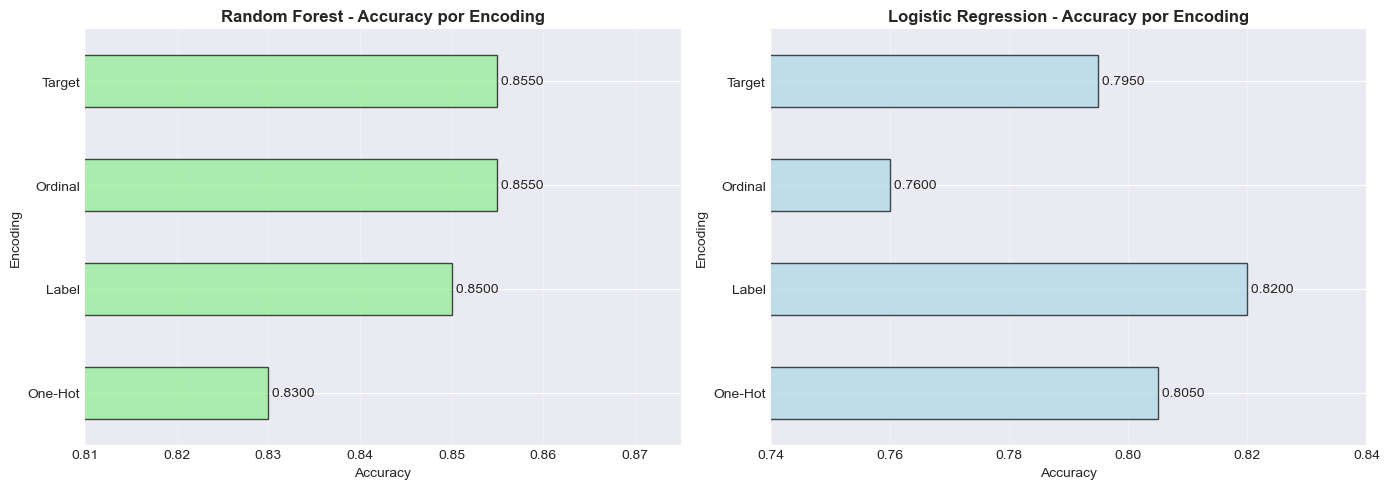


📊 Análise dos Resultados:

🏆 Melhor para Random Forest: Ordinal (0.8550)
🏆 Melhor para Logistic Regression: Label (0.8200)

📌 Conclusões:
1. Random Forest: Funciona bem com qualquer encoding (não sensível)
2. Logistic Regression: One-Hot e Target Encoding tendem a funcionar melhor
3. Target Encoding pode dar overfitting - use com cuidado!
4. One-Hot é mais seguro e funciona bem na maioria dos casos


In [20]:
# Visualizar comparação
results_df = pd.DataFrame(results).T

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
results_df['RF'].plot(kind='barh', ax=axes[0], color='lightgreen', alpha=0.7, edgecolor='black')
axes[0].set_title('Random Forest - Accuracy por Encoding', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Accuracy')
axes[0].set_ylabel('Encoding')
axes[0].set_xlim([results_df['RF'].min() - 0.02, results_df['RF'].max() + 0.02])
axes[0].grid(True, alpha=0.3, axis='x')

for idx, (enc, score) in enumerate(zip(results_df.index, results_df['RF'])):
    axes[0].text(score, idx, f' {score:.4f}', va='center', fontsize=10)

# Logistic Regression
results_df['LR'].plot(kind='barh', ax=axes[1], color='lightblue', alpha=0.7, edgecolor='black')
axes[1].set_title('Logistic Regression - Accuracy por Encoding', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Accuracy')
axes[1].set_ylabel('Encoding')
axes[1].set_xlim([results_df['LR'].min() - 0.02, results_df['LR'].max() + 0.02])
axes[1].grid(True, alpha=0.3, axis='x')

for idx, (enc, score) in enumerate(zip(results_df.index, results_df['LR'])):
    axes[1].text(score, idx, f' {score:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Análise
print("\n📊 Análise dos Resultados:\n")

best_rf = results_df['RF'].idxmax()
best_lr = results_df['LR'].idxmax()

print(f"🏆 Melhor para Random Forest: {best_rf} ({results_df.loc[best_rf, 'RF']:.4f})")
print(f"🏆 Melhor para Logistic Regression: {best_lr} ({results_df.loc[best_lr, 'LR']:.4f})")

print("\n📌 Conclusões:")
print("1. Random Forest: Funciona bem com qualquer encoding (não sensível)")
print("2. Logistic Regression: One-Hot e Target Encoding tendem a funcionar melhor")
print("3. Target Encoding pode dar overfitting - use com cuidado!")
print("4. One-Hot é mais seguro e funciona bem na maioria dos casos")

## 📋 Tabela Resumo

Quando usar cada encoding?

In [21]:
# Criar tabela resumo
summary_data = {
    'Encoding': ['One-Hot', 'Label', 'Ordinal', 'Target', 'Frequency'],
    'Tipo Feature': ['Nominal', 'Target/Árvores', 'Ordinal', 'Alta Cardinalidade', 'Qualquer'],
    'Dimensões': ['Aumenta', 'Mantém', 'Mantém', 'Mantém', 'Mantém'],
    'Data Leakage': ['Não', 'Não', 'Não', 'SIM (cuidado!)', 'Não'],
    'Melhor Para': ['LR, SVM, NN', 'RF, XGB', 'Todos', 'RF, XGB', 'RF, XGB'],
    'Complexidade': ['Fácil', 'Fácil', 'Médio', 'Difícil', 'Fácil']
}

summary_df = pd.DataFrame(summary_data)

print("\n📊 TABELA RESUMO - QUANDO USAR CADA ENCODING\n")
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("\n✅ RECOMENDAÇÕES GERAIS:")
print("\n1️⃣ Começe com One-Hot Encoding (mais seguro)")
print("2️⃣ Use Ordinal para features com ordem natural")
print("3️⃣ Target Encoding para muitas categorias (com validação!)")
print("4️⃣ Evite Label para features nominais em LR/SVM")
print("5️⃣ Random Forest funciona com qualquer encoding")
print("\n" + "="*80)


📊 TABELA RESUMO - QUANDO USAR CADA ENCODING

 Encoding       Tipo Feature Dimensões   Data Leakage Melhor Para Complexidade
  One-Hot            Nominal   Aumenta            Não LR, SVM, NN        Fácil
    Label     Target/Árvores    Mantém            Não     RF, XGB        Fácil
  Ordinal            Ordinal    Mantém            Não       Todos        Médio
   Target Alta Cardinalidade    Mantém SIM (cuidado!)     RF, XGB      Difícil
Frequency           Qualquer    Mantém            Não     RF, XGB        Fácil


✅ RECOMENDAÇÕES GERAIS:

1️⃣ Começe com One-Hot Encoding (mais seguro)
2️⃣ Use Ordinal para features com ordem natural
3️⃣ Target Encoding para muitas categorias (com validação!)
4️⃣ Evite Label para features nominais em LR/SVM
5️⃣ Random Forest funciona com qualquer encoding



## ✅ Resumo e Próximos Passos

### 🎯 O que aprendemos?

1. **One-Hot Encoding**
   - Cria colunas binárias
   - Melhor para features nominais
   - Aumenta dimensionalidade

2. **Label Encoding**
   - Números sequenciais
   - Cria ordem artificial
   - OK para árvores, evitar em LR/SVM

3. **Ordinal Encoding**
   - Para features com ordem
   - Você define a hierarquia
   - Funciona bem em todos

4. **Target Encoding**
   - Média do target
   - Ótimo para alta cardinalidade
   - Cuidado com overfitting!

5. **Frequency Encoding**
   - Baseado em frequência
   - Simples e seguro
   - Pode ter colisões

### 📚 Próximo Notebook

**02c-feature-creation.ipynb**
- Criar features de tempo
- Agregações
- Combinações matemáticas
- Feature selection

---

**🎉 Parabéns! Você dominou encodings categóricos!** 💪